**********************************************************************************************
# Initialization
**********************************************************************************************

In [31]:
# Load librarie
import numpy as np
import pandas as pd

from scipy.stats import uniform
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
import time

from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
# from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from pickle import dump
from pickle import load
##############################################################################



In [32]:
# ''' Remove this comment out if needs to be used
from google.colab import drive
drive.mount('/content/drive')
# '''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# ''' Remove this comment out if needs to be used
import os
##############################################################################

os.chdir("/content/drive/My Drive/DataMining/Final_Project")
!ls
# '''

 Bassam_Arnaout.txt		    dataset.pkl
 DataMiningFinalProject-All.ipynb  'Gradient Boosting_finalized_model.sav'
 DataMiningFinalProject.ipynb


**********************************************************************************************
# Functions
**********************************************************************************************

ROC Curve plot function

This is a callable ROC curve plot function. We will use this function to plot ROC Curve for all the models. We have used Seaborn package.

In [34]:
import seaborn as sns
sns.set('talk', 'whitegrid', 'dark', font_scale=1,rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")


def plotRocCurve(pred,truth, lab):
  import matplotlib.pyplot as plt

  # AUC Curve
  # y_pred_proba = classifier.predict_proba(pred)[:,1]
  fpr, tpr, thresholds = metrics.roc_curve(truth,pred) 
  auc = metrics.auc(fpr, tpr)#metrics.roc_auc_score(fpr, tpr)
  plt.plot(fpr,tpr,label= lab + ", auc="+str(auc))
  plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
  plt.legend(loc="lower right")
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic (ROC) ')
  plt.show()

  print('\nArea under ROC curve is (AUC) :',str(format(auc,'.6f') ))

Confusion Matrix Viz function

This is a callable Confusion Matrix Visualization function. We have used this function to visualize True positives, True Negatives, False Positives and False Negatives for all the models.

In [35]:
import itertools
def plot_confusion_matrix(Y,Ypred, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(Y, Ypred, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
def accuracy(confusion_matrix):
   diagonal_sum = confusion_matrix.trace()
   sum_of_all_elements = confusion_matrix.sum()
   return diagonal_sum / sum_of_all_elements

**********************************************************************************************
# 1.load data
**********************************************************************************************

In [37]:
# 1.load data
##############################################################################
data = pd.read_pickle('dataset.pkl')

data.columns = ['id', 'dates', 'transaction_amount', 'days_before_request',
                       'loan_amount', 'loan_date', 'isDefault']

print('\n')
print('*' * 80)
print('\n')
print('Bank Customer Transactions Dataset:\n')
# print(data.head())
data



********************************************************************************


Bank Customer Transactions Dataset:



,id,dates,transaction_amount,days_before_request,loan_amount,loan_date,isDefault
0,"[id, 00076211-9BBD-4E06-82C2-E9FB7B102964-750]","[dates, [2017-05-19, 2017-05-29, 2017-05-31, 2...","[transaction_amount, [[-60.0], [0.02], [0.01],...","[days_before_request, [[79.0], [79.0], [76.0],...","[loan_amount, 750]","[loan_date, 2017-08-16]","[isDefault, 1]"
1,"[id, 0009107F-8F57-441C-A590-5773992261A9-500]","[dates, [2017-11-20, 2017-11-20, 2017-11-20, 2...","[transaction_amount, [[-68.93], [-23.7], [-0.5...","[days_before_request, [[12.0], [12.0], [12.0],...","[loan_amount, 500]","[loan_date, 2018-02-17]","[isDefault, 1]"
2,"[id, 000B47CB-514F-446C-B7BE-2F2D304E2F4D-1000]","[dates, [2017-05-29, 2017-05-29, 2017-05-29, 2...","[transaction_amount, [[-23.5], [-9.78], [-14.2...","[days_before_request, [[87.0], [87.0], [87.0],...","[loan_amount, 1000]","[loan_date, 2017-08-25]","[isDefault, 0]"
3,"[id, 000CAC25-AFBD-455D-9367-D23FB38D17B0-250]","[dates, [2017-08-17, 2017-08-17, 2017-08-17, 2...","[transaction_amount, [[-360.0], [105.82], [192...","[days_before_request, [[88.0], [88.0], [88.0],...","[loan_amount, 250]","[loan_date, 2017-11-12]","[isDefault, 0]"
4,"[id, 000E9C38-708E-40F7-8ABC-9DF55B77BB54-500]","[dates, [2016-08-29, 2016-08-29, 2016-08-29, 2...","[transaction_amount, [[-2.16], [-4.96], [-17.4...","[days_before_request, [[88.0], [88.0], [87.0],...","[loan_amount, 500]","[loan_date, 2016-11-25]","[isDefault, 0]"
...,...,...,...,...,...,...,...
14995,"[id, FFEA064F-0D58-4CB8-A42F-F54E90EC0816-1000]","[dates, [2017-04-17, 2017-04-20, 2017-04-27, 2...","[transaction_amount, [[-150.0], [6.52], [6.52]...","[days_before_request, [[62.0], [62.0], [62.0],...","[loan_amount, 1000]","[loan_date, 2017-07-12]",[]
14996,"[id, FFEADE25-11CF-488D-B722-EDF6649A3F52-750]","[dates, [2017-03-07, 2017-03-08, 2017-03-08, 2...","[transaction_amount, [[350.0], [-23.21], [-48....","[days_before_request, [[18.0], [18.0], [18.0],...","[loan_amount, 750]","[loan_date, 2017-06-02]",[]
14997,"[id, FFEC371F-8F61-469D-8B9B-360504AB803A-750]","[dates, [2017-08-21, 2017-08-23, 2017-08-23, 2...","[transaction_amount, [[-108.09], [-10.0], [-12...","[days_before_request, [[75.0], [74.0], [74.0],...","[loan_amount, 750]","[loan_date, 2017-11-16]",[]
14998,"[id, FFF1961C-9082-4EC1-AEAF-0DACD21EF80A-500]","[dates, [2017-05-16, 2017-05-17, 2017-05-18, 2...","[transaction_amount, [[-10.0], [6.03], [-4.2],...","[days_before_request, [[66.0], [66.0], [66.0],...","[loan_amount, 500]","[loan_date, 2017-08-13]",[]


## Formulate Data to new prospective

In [38]:
# Formulate Data to new prospective
##############################################################################

x_data = np.zeros([15000,6])
y_label = np.zeros(15000)

cust_id_list = []

for cust in np.arange(0,15000):
  cust_id = data['id'][cust][1]
  cust_id_list.append(cust_id)
  ts = data['transaction_amount'][cust][1]
  sum_ts = np.sum(ts)
  loan_amt = data['loan_amount'][cust][1]

  if cust <=9999:
    isdef = data['isDefault'][cust][1]
    y_label[cust] = isdef
    # print(y_label)

  x_data[cust,0] = np.mean(ts[np.where(ts>0)])
  x_data[cust,1] = np.mean(ts[np.where(ts<0)])
  x_data[cust,2] = sum_ts
  x_data[cust,3] = np.max(ts)
  x_data[cust,4] = np.min(ts)
  x_data[cust,5] = loan_amt


dataframe1 = pd.DataFrame(np.array(cust_id_list), columns = ['id'])

coulumsName = ['mean_+ts', 'mean_-ts', 'sum_ts', 'max_ts',
                       'min_ts', 'loan_amount']
dataframe2 = pd.DataFrame.from_records(x_data, columns = coulumsName)
dataframe2['isDefault'] = y_label
dataframe2

# Place the DataFrames side by side
data_formulated = pd.concat([dataframe1, dataframe2], axis=1)
# data_formulated = data_formulated.drop('id', axis=1)

#replace empty value with the average value for the specified column
data_formulated.fillna(data_formulated.mean(),inplace = True)

print('\n')
print('*' * 80)
print('\n')
print('New Formulated Data For Bank Customer Transactions Dataset:\n')
data_formulated

data_to_use = data_formulated.head(10000)
data_to_use = data_to_use.drop('id', axis=1)
data_to_use

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




********************************************************************************


New Formulated Data For Bank Customer Transactions Dataset:



<ipython-input-38-41ca6d7582ee>:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_formulated.fillna(data_formulated.mean(),inplace = True)


,mean_+ts,mean_-ts,sum_ts,max_ts,min_ts,loan_amount,isDefault
0,440.055172,-78.789942,-711.48,3082.73,-562.00,750.0,1.0
1,178.169900,-59.946844,911.98,1507.26,-1507.26,500.0,1.0
2,921.300000,-56.448514,366.63,1639.35,-811.23,1000.0,0.0
3,197.990000,-46.844850,332.54,1000.00,-900.00,250.0,0.0
4,375.659231,-22.771498,-285.56,806.39,-320.09,500.0,0.0
...,...,...,...,...,...,...,...
9995,376.868421,-64.037565,-203.82,952.00,-500.00,500.0,1.0
9996,607.173846,-102.632881,577.91,3414.64,-3000.00,500.0,0.0
9997,561.985625,-55.646306,255.30,1355.30,-1300.00,500.0,1.0
9998,303.129200,-77.922203,448.94,3909.00,-1120.00,750.0,1.0


**********************************************************************************************
# 2.Summarize Data
**********************************************************************************************

**********************************************************************************************
## 2.A Understand the Data With Descriptive Statistics
**********************************************************************************************
We must understand the data in order to get the best results. We will discover 7 recipes that we can use in Python to better understand our machine learning data. 
1. Take a peek at our raw data.
2. Review the dimensions of our dataset.
3. Review the data types of attributes in our data.
4. Summarize the distribution of instances across classes in our dataset.
5. Summarize our data using descriptive statistics.
6. Understand the relationships in our data using correlations.
7. Review the skew of the distributions of each attribute.

2.A.1. Peek at our Data

In [39]:
#2.A.1. Peek at our Data
##############################################################################

#review the first 20 rows
print('\n')
print('*' * 80)
print('\n')
print('New Formulated Data For Bank Customer Transactions Dataset:\n')
peek = data_to_use.head(5)
peek
# We can confirm that the scales for the attributes are all over the place 
# because of the differing units. We may benefit from some transforms later on.



********************************************************************************


New Formulated Data For Bank Customer Transactions Dataset:



,mean_+ts,mean_-ts,sum_ts,max_ts,min_ts,loan_amount,isDefault
0,440.055172,-78.789942,-711.48,3082.73,-562.00,750.0,1.0
1,178.169900,-59.946844,911.98,1507.26,-1507.26,500.0,1.0
2,921.300000,-56.448514,366.63,1639.35,-811.23,1000.0,0.0
3,197.990000,-46.844850,332.54,1000.00,-900.00,250.0,0.0
4,375.659231,-22.771498,-285.56,806.39,-320.09,500.0,0.0


2.A.2.Dimensions of Our Data

In [40]:
#2.A.2.Dimensions of Our Data
##############################################################################

print(data_to_use.shape)

(10000, 7)


2.A.3.Data Type For Each Attribute

In [41]:
#2.A.3.Data Type For Each Attribute
##############################################################################

# types = data_to_use.dtypes
# print(types)
print('\n')
print('*' * 80)
print('\n')
print('Data Type:\n')
data_to_use.info()

# We can see that all of the attributes are numeric of integers (int) type



********************************************************************************


Data Type:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   mean_+ts     10000 non-null  float64
 1   mean_-ts     10000 non-null  float64
 2   sum_ts       10000 non-null  float64
 3   max_ts       10000 non-null  float64
 4   min_ts       10000 non-null  float64
 5   loan_amount  10000 non-null  float64
 6   isDefault    10000 non-null  float64
dtypes: float64(7)
memory usage: 547.0 KB


2.A.4.Descriptive Statistics

In [42]:
#2.A.4.Descriptive Statistics
##############################################################################

# Descriptive statistics can give us great insight into the shape of each attribute. Often we can
# create more summaries than we have time to review. The describe() function on the Pandas
# DataFrame lists 8 statistical properties of each attribute. They are:
#  Count.
#  Mean.
#  Standard Deviation.
#  Minimum Value.
#  25th Percentile.
#  50th Percentile (Median).
#  75th Percentile.
#  Maximum Value.
print('\n')
print('*' * 80)
print('\n')
print('Descriptive Statistics For Bank Customer Transactions Dataset:\n')
pd.set_option('display.width', 100)
# pd.set_option('precision', 3)
description = data_to_use.describe()
description

# We now have a better feeling for how different the attributes are. The min and max values
# as well as the means vary a lot. We are likely going to get better results by rescaling the data
# in some way.

# Data has interestingly differing mean values.
# There may be some benefit from standardizing the data.



********************************************************************************


Descriptive Statistics For Bank Customer Transactions Dataset:



,mean_+ts,mean_-ts,sum_ts,max_ts,min_ts,loan_amount,isDefault
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,437.504574,-72.640995,-21.745755,1997.696858,-1176.881211,640.701500,0.270000
std,281.054210,44.357642,1933.676923,2485.342044,1858.669573,214.862926,0.443982
min,1.896563,-1260.975055,-114112.790000,-1.500000,-99746.290000,250.000000,0.000000
25%,256.323145,-86.026756,-266.147500,1017.827500,-1300.000000,500.000000,0.000000
50%,381.624209,-62.844573,22.795000,1415.705000,-877.090000,600.000000,0.000000
75%,546.882644,-46.514448,340.352500,2132.050000,-585.000000,750.000000,1.000000
max,6148.792000,-9.818263,67733.550000,83661.060000,-22.390000,1250.000000,1.000000


2.A.5.Class Distribution (Classication Only)

In [43]:
# 2.A.5.Class Distribution (Classication Only)
##############################################################################

print('\n')
print('*' * 80)
# print('\n')
print('Class Distribution:\n')
class_counts = data_to_use.groupby('isDefault').size()
print(class_counts)

# We can see that the classes are not balanced between output values.



********************************************************************************
Class Distribution:

isDefault
0.0    7300
1.0    2700
dtype: int64


2.A.6.Correlations Between Attributes

In [44]:
# 2.A.6.Correlations Between Attributes
##############################################################################

# Correlation refers to the relationship between two variables and how they may or may not
# change together. The most common method for calculating correlation is Pearson's Correlation
# Coecient, that assumes a normal distribution of the attributes involved. A correlation of -1
# or 1 shows a full negative or positive correlation respectively. Whereas a value of 0 shows no
# correlation at all. Some machine learning algorithms like linear and logistic regression can suffer
# poor performance if there are highly correlated attributes in your dataset. As such, it is a good
# idea to review all of the pairwise correlations of the attributes in our dataset. We can use the
# corr() function on the Pandas DataFrame to calculate a correlation matrix.

# Pairwise Pearson correlations
print('\n')
print('*' * 80)
print('\n')
print('Correlations Marix Between Attributes :\n ')
correlations = data_to_use.corr(method='pearson')
correlations

# This is interesting. We can see that many of the attributes have a weak correlation



********************************************************************************


Correlations Marix Between Attributes :
 


,mean_+ts,mean_-ts,sum_ts,max_ts,min_ts,loan_amount,isDefault
mean_+ts,1.000000,-0.513319,0.045878,0.499767,-0.334979,0.043166,-0.030770
mean_-ts,-0.513319,1.000000,0.046586,-0.483769,0.493931,-0.025310,-0.038085
sum_ts,0.045878,0.046586,1.000000,0.100143,0.357910,0.000379,0.018381
max_ts,0.499767,-0.483769,0.100143,1.000000,-0.638064,0.025349,-0.019187
min_ts,-0.334979,0.493931,0.357910,-0.638064,1.000000,-0.016605,0.019854
loan_amount,0.043166,-0.025310,0.000379,0.025349,-0.016605,1.000000,-0.165532
isDefault,-0.030770,-0.038085,0.018381,-0.019187,0.019854,-0.165532,1.000000


2.A.7.Skew of Univariate Distributions

In [45]:
# 2.A.7.Skew of Univariate Distributions
##############################################################################

# Skew refers to a distribution that is assumed Gaussian (normal or bell curve) that is shifted or
# squashed in one direction or another. Many machine learning algorithms assume a Gaussian
# distribution. Knowing that an attribute has a skew may allow you to perform data preparation
# to correct the skew and later improve the accuracy of your models. We can calculate the skew
# of each attribute using the skew() function on the Pandas DataFrame.

# Skewness refers to distortion or asymmetry in a symmetrical bell curve, 
# or normal distribution, in a set of data. If the curve is shifted to the 
# left or to the right, it is said to be skewed. Skewness can be quantified 
# as a representation of the extent to which a given distribution varies 
# from a normal distribution

# Skew for each attribute
print('\n')
print('*' * 80)
print('\n')
print('Skew of Univariate Distributions:\n ')
skew = data_to_use.skew()
print(skew)



********************************************************************************


Skew of Univariate Distributions:
 
mean_+ts        3.260245
mean_-ts       -5.275530
sum_ts        -18.299518
max_ts         10.676872
min_ts        -21.416014
loan_amount     0.706252
isDefault       1.036286
dtype: float64


**********************************************************************************************
## 2.B Understand the Data With Visualization
**********************************************************************************************
We must understand the data in order to get the best results from machine learning algorithms.
The fastest way to learn more about the data is to use data visualization.

plot the data using:

**Univariate Plots**
1.   Histograms.
2.   Density Plots.
3.   Box and Whisker Plots.

**Multivariate Plots**
4.   Correlation Matrix Plot.
5.   Scatter Plot Matrix.
  
  




**********************************************************************************************
### (2.B.1)Univariate Plots
**********************************************************************************************
1.   Histograms.
2.   Density Plots.
3.   Box and Whisker Plots.

**Histograms**

A fast way to get an idea of the distribution of each attribute is to look at histograms. Histograms
group data into bins and provide us a count of the number of observations in each bin. From
the shape of the bins we can quickly get a feeling for whether an attribute is Gaussian, skewed
or even has an exponential distribution. It can also help us see possible outliers.



********************************************************************************


Univariate Histograms:
 


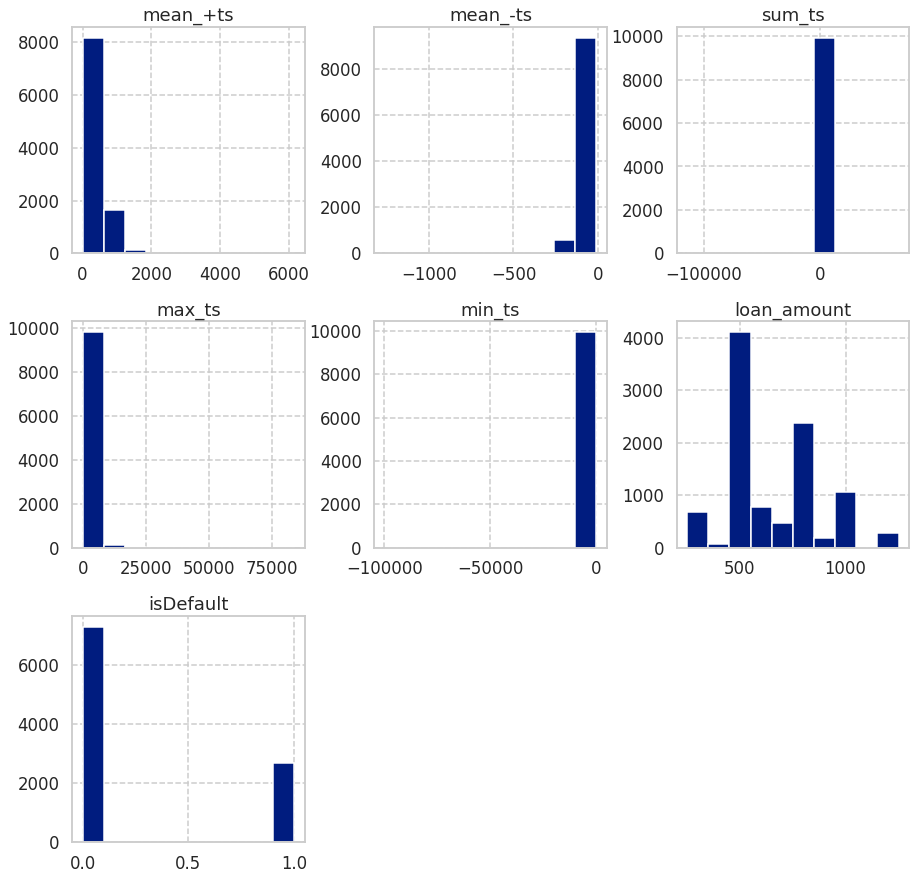

In [46]:
# Univariate Histograms
##############################################################################

print('\n')
print('*' * 80)
print('\n')
print('Univariate Histograms:\n ')
data_to_use.hist(figsize=(15,15))
plt.show()

# We can see that no attributes  has an exponential
# distribution. We can also see that perhaps some attributes
# have a Gaussian or nearly Gaussian distribution. This is interesting because many machine learning
# techniques assume a Gaussian univariate distribution on the input variables.
# This is useful to note as we can use algorithms that can exploit this assumption (Gaussian distribution).

#Some has binomial distribution such as Gender

#It also looks like some attributes may be skewed Gaussian distributions, which
# might be helpful later with transforms.

Density Plots
Density plots are another way of getting a quick idea of the distribution of each attribute. The plots look like an abstracted histogram with a smooth curve drawn through the top of each bin, much like your eye tried to do with the histograms.



********************************************************************************


Univariate Density Plots:
 


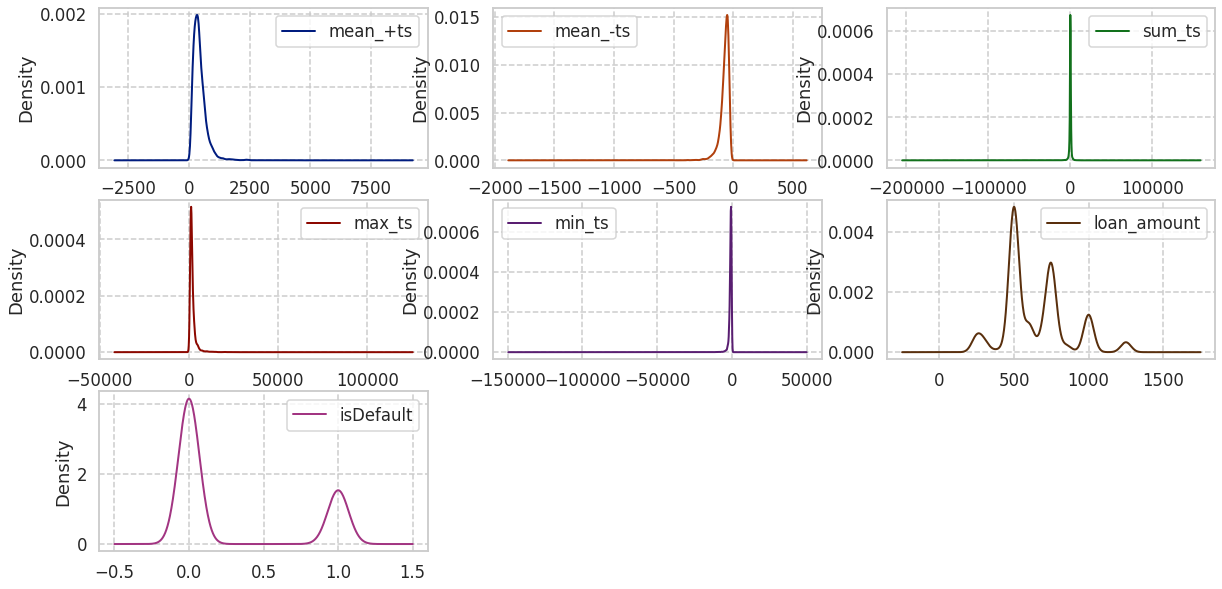


Skew of Univariate Distributions:
 
mean_+ts        3.260245
mean_-ts       -5.275530
sum_ts        -18.299518
max_ts         10.676872
min_ts        -21.416014
loan_amount     0.706252
isDefault       1.036286
dtype: float64


In [47]:
# Univariate Density Plots
##############################################################################

print('\n')
print('*' * 80)
print('\n')
print('Univariate Density Plots:\n ')
data_to_use.plot(kind='density', subplots=True, layout=(3,3), sharex=False)
plt.show()

print('\nSkew of Univariate Distributions:\n ')
skew = data_to_use.skew()
print(skew)

# This is useful, we can see that some of the attributes have a skewed distribution. A power
# transform like a Box-Cox transform that can correct for the skew in distributions might be
# useful.

# This helps point out the skew in many distributions so much so that data looks like outliers
# (e.g. beyond the whisker of the plots).

**Box and Whisker Plots**

Another useful way to review the distribution of each attribute is to use Box and Whisker Plots
or boxplots for short. Boxplots summarize the distribution of each attribute, drawing a line for
the median (middle value) and a box around the 25th and 75th percentiles (the middle 50% of
the data). The whiskers give an idea of the spread of the data and dots outside of the whiskers
show candidate outlier values (values that are 1.5 times greater than the size of spread of the
middle 50% of the data).



********************************************************************************


Box and Whisker Plots:
 


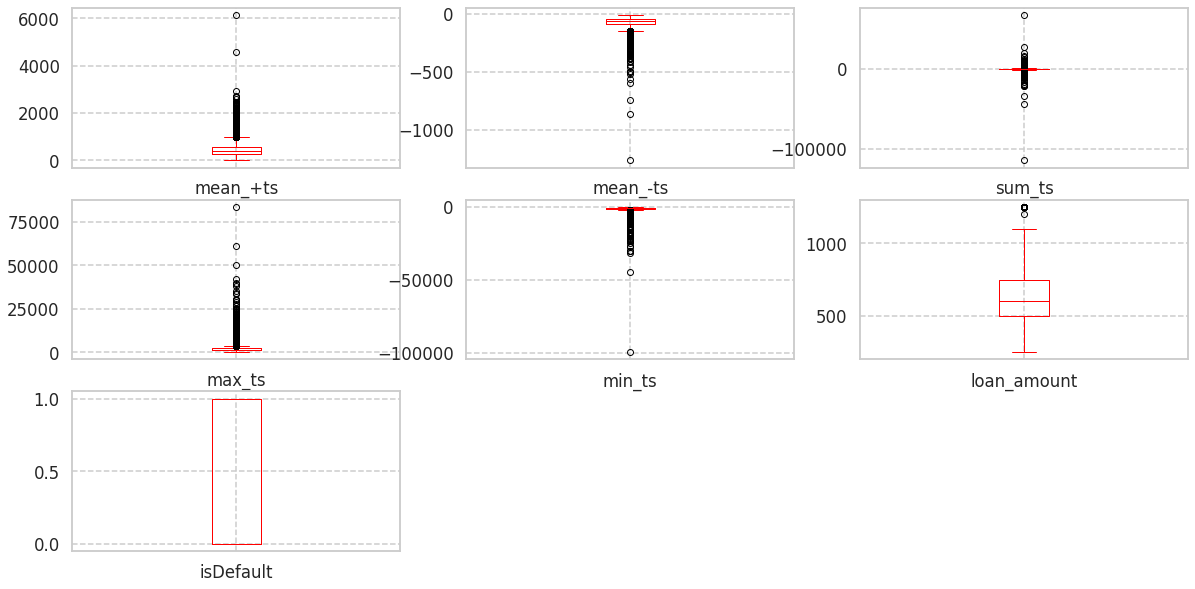

In [48]:
# Box and Whisker Plots
##############################################################################

print('\n')
print('*' * 80)
print('\n')
print('Box and Whisker Plots:\n ')
s = data_to_use.plot(kind='box', color='red', subplots=True, layout=(3,3), sharex=False, sharey=False)

# We can see that attributes do have quite dierent spreads. Given(if) the scales are the same, it
# may suggest some benefit in standardizing the data for modelling to get all of the means lined
# up.

**********************************************************************************************
### (2.B.2)Multivariate Plots
**********************************************************************************************
This section describes two plots that show the interactions between multiple variables
in the dataset.

1.   Correlation Matrix Plot.
2.   Scatter Plot Matrix.





**Correlation Matrix Plot**

Correlation gives an indication of how related the changes are between two variables. If two
variables change in the same direction they are positively correlated. If they change in opposite
directions together (one goes up, one goes down), then they are negatively correlated. We can
calculate the correlation between each pair of attributes. This is called a correlation matrix. we
can then plot the correlation matrix and get an idea of which variables have a high correlation with each other. This is useful to know, because some machine learning algorithms like linear and logistic regression can have poor performance if there are highly correlated input variables in our data.



********************************************************************************


Correlation Matrix Plot:
 


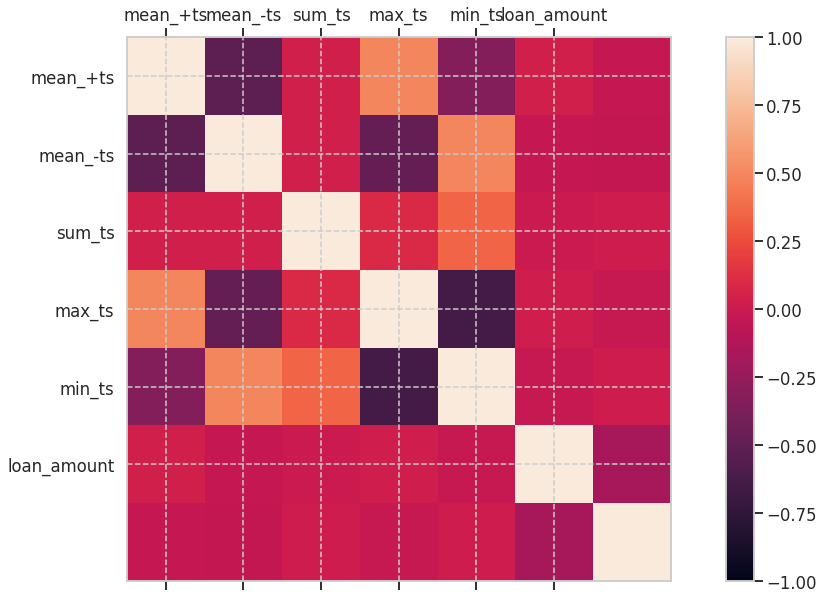

In [49]:
# Correlation Matrix Plot
##############################################################################

print('\n')
print('*' * 80)
print('\n')
print('Correlation Matrix Plot:\n ')
correlations = data_to_use.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,6,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
names = list(data_to_use.columns)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

# if there is strong correlatoin(+ve or -ve), this suggest candidates for removal
# to better improve accuracy of models later on.

**********************************************************************************************
# 3.Prepare the Data For Machine Learning
**********************************************************************************************
Many machine learning algorithms make assumptions about the data. It is often a very good
idea to prepare the data in such way to best expose the structure of the problem to the machine
learning algorithms that we intend to use. We will prepare
the data for machine learning (Data Transforms) in Python using scikit-learn:


1. Rescale data.
2. Feature Selection.

**********************************************************************************************
## A. Data Transforms
**********************************************************************************************

Need For Data Pre-processing
We almost always need to pre-process the data. It is a required step. A difficulty is that diff
erent algorithms make different assumptions about the data and may require different transforms. Further, when we follow all of the rules and prepare the data, sometimes algorithms can deliver better results without pre-processing. Generally, We would recommend creating many diff
erent views and transforms of the data, then exercise a handful of algorithms on each view of the dataset. This will help us to flush out which data transforms might be better at exposing the structure of our problem in general.

**********************************************************************************************
### Rescale Data
**********************************************************************************************
When the data is comprised of attributes with varying scales, many machine learning algorithms
can benefit from rescaling the attributes to all have the same scale. Often this is referred to
as normalization and attributes are often rescaled into the range between 0 and 1. This is
useful for optimization algorithms used in the core of machine learning algorithms like gradient
descent. It is also useful for algorithms that weight inputs like regression and neural networks
and algorithms that use distance measures like k-Nearest Neighbors. We can rescale the data
using scikit-learn using the MinMaxScaler class

In [50]:
''' Remove this comment out if needs to be used

# Rescale Data
##############################################################################

no_of_coulmns = data_to_use.shape[1]
no_of_attrib = no_of_coulmns -1

array = data_to_use.values

X = array[:,0:no_of_attrib]
Y = array[:,no_of_attrib]


from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)


dataframe = pd.DataFrame.from_records(data=X_scale, 
                                      columns=data_to_use.drop(columns=['isDefault']).columns)

dataframe['isDefault'] = Y

data_to_use = dataframe
data_to_use
'''

" Remove this comment out if needs to be used\n\n# Rescale Data\n##############################################################################\n\nno_of_coulmns = data_to_use.shape[1]\nno_of_attrib = no_of_coulmns -1\n\narray = data_to_use.values\n\nX = array[:,0:no_of_attrib]\nY = array[:,no_of_attrib]\n\n\nfrom sklearn import preprocessing\nmin_max_scaler = preprocessing.MinMaxScaler()\nX_scale = min_max_scaler.fit_transform(X)\n\n\ndataframe = pd.DataFrame.from_records(data=X_scale, \n                                      columns=data_to_use.drop(columns=['isDefault']).columns)\n\ndataframe['isDefault'] = Y\n\ndata_to_use = dataframe\ndata_to_use\n"

**********************************************************************************************
## B. Feature Selection For Machine Learning
**********************************************************************************************

The data features that we use to train our machine learning models have a huge influence on the performance we can achieve. Irrelevant or partially relevant features can negatively impact model performance. We will discover automatic feature selection technique (Feature Importance) that we can use to prepare our machine learning data in Python with scikit-learn. 

**********************************************************************************************
### Finding Important Features Using RandomForestClassifier
**********************************************************************************************



********************************************************************************

Finding Important Features


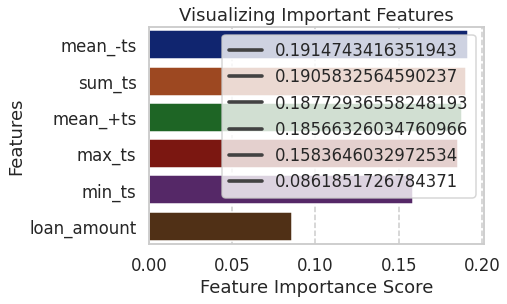


Importance of Features: 

 mean_-ts       0.191474
sum_ts         0.190583
mean_+ts       0.187729
max_ts         0.185663
min_ts         0.158365
loan_amount    0.086185
dtype: float64


In [51]:
# ''' Remove this comment out if needs to be used

# Finding Important Features Using RandomForestClassifier
##############################################################################

no_of_coulmns = data_to_use.shape[1]
no_of_attrib = no_of_coulmns -1

array = data_to_use.values

X = array[:,0:no_of_attrib]
Y = array[:,no_of_attrib]

classifier_randomForest = RandomForestClassifier(n_estimators=100)

#Fitting the training data to the network
classifier_randomForest.fit(X, Y)

feature_imp = pd.Series(classifier_randomForest.feature_importances_,index=data_to_use.drop(columns=['isDefault']).columns).sort_values(ascending=False)

print('\n')
print('*' * 80)
print('\nFinding Important Features')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend(feature_imp)
plt.show()

print('\nImportance of Features: \n\n',feature_imp)
# '''

In [52]:
''' Remove this comment out if needs to be used
#Remove some features from Dataset
list_to_delete=[]; list_to_delete.clear()

print('\n')
print('*' * 80)
print('\nNew Features after removing some less important feature(s):')

# print('\n\n')
for i in range(-1,0):
  # print(i)
  list_to_delete.append(feature_imp.index[i])

# Delete multiple columns from the dataframe
data_to_use = data_to_use.drop(list_to_delete, axis=1)
data_to_use
'''

" Remove this comment out if needs to be used\n#Remove some features from Dataset\nlist_to_delete=[]; list_to_delete.clear()\n\nprint('\n')\nprint('*' * 80)\nprint('\nNew Features after removing some less important feature(s):')\n\n# print('\n\n')\nfor i in range(-1,0):\n  # print(i)\n  list_to_delete.append(feature_imp.index[i])\n\n# Delete multiple columns from the dataframe\ndata_to_use = data_to_use.drop(list_to_delete, axis=1)\ndata_to_use\n"

**********************************************************************************************
# 4.Evaluate Some Algorithms
**********************************************************************************************
Now it is time to create some models of the data and estimate their accuracy on unseen data.
Here is what we are going to cover in this step:
1. Separate out a validation/test dataset.
2. Setup the test harness to use 10-fold cross validation.
3. Build different models to predict species from 
ower measurements
4. Select the best model.

**********************************************************************************************
## 4.1 Create a Validation/Test Dataset
**********************************************************************************************
We will split the loaded dataset into two, 67%
of which we will use to train our models and 33% that we will hold back as a validation dataset.


In [53]:
# Create a Validation/Test Dataset
##############################################################################

# Split-out validation dataset
no_of_coulmns = data_to_use.shape[1]
no_of_attrib = no_of_coulmns -1

array = data_to_use.values

X = array[0:10000,0:no_of_attrib]
Y = array[0:10000,no_of_attrib]

seed = 7

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.33,random_state=seed)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5,random_state=seed)

print('\n')
print('*' * 80)
print('\nCreate a Training, Validation & Test Dataset:\n')
# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Validation set has {} samples.".format(X_validation.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

# We now have training data in the X train and Y train for preparing models and a
# X validation/test and Y validation/test sets that we can use later.



********************************************************************************

Create a Training, Validation & Test Dataset:

Training set has 6700 samples.
Validation set has 1650 samples.
Testing set has 1650 samples.


**********************************************************************************************
## 4.2 Test Harness
**********************************************************************************************
We will use 10-fold cross validation to estimate accuracy. This will split our dataset into 10
parts, train on 9 and test on 1 and repeat for all combinations of train-test splits. We are using
the metric of roc_auc to evaluate models. We will be using the scoring variable when we run build and
evaluate each model next.

**********************************************************************************************
## 4.3 Build Models
**********************************************************************************************
We don't know which algorithms would be good on this problem or what con
figurations to use.

Let's build and evaluate our models using **Spot-Check Classification Algorithms:**


**What Techniques to Use When**

Generally k-fold cross validation is the gold standard for evaluating the performance of a machine learning algorithm on unseen data with k set to 3, 5, or 10.
Using a train/test split is good for speed when using a slow algorithm and produces performance estimates with lower bias when using large datasets.
Techniques like leave-one-out cross validation and repeated random splits can be useful intermediates when trying to balance variance in the estimated performance, model training speed and dataset size.
The best advice is to experiment and 
find a technique for our problem that is fast and produces reasonable estimates of performance that we can use to make decisions. If in doubt, use 10-fold cross validation.

**********************************************************************************************
### Spot-Check Classiffication Algorithms
**********************************************************************************************
Spot-checking is a way of discovering which algorithms perform well on our machine learning
problem. We cannot know which algorithms are best suited to our problem beforehand. We
must try a number of methods and focus attention on those that prove themselves the most
promising. 

In [54]:
# Spot-Check Algorithms
##############################################################################
start=time.time()

models = [] ; models.clear
modelName = []; modelName.clear

models.append(('LR', LogisticRegression(C= 0.001, solver='lbfgs', multi_class='auto', max_iter=1000)))
modelName.append('LR')
# Linear Discriminant Analysis
models.append(('LDA', LinearDiscriminantAnalysis()))
modelName.append('LDA')
# KNN Classification
models.append(('KNN', KNeighborsClassifier(n_neighbors=7)))
modelName.append('KNN')
# Gaussian Naive Bayes Classification
models.append(('NB', GaussianNB(priors=None, var_smoothing=1e-09)))
modelName.append('NB')
# Classication and Regression Trees (CART or just decision trees) Calssification
models.append(('CART', DecisionTreeClassifier()))
modelName.append('CART')
# Support Vector Machines (or SVM) Calssification
models.append(('SVM', SVC(gamma='auto', C=10, probability=True)))
modelName.append('SVM')
# XGBoost Calssification
# models.append(('XGBoost', XGBClassifier()))
# modelName.append('XGBoost')
# MLPClassifier
models.append(('MLP', MLPClassifier(activation='tanh', 
                                    alpha= 0.0001, hidden_layer_sizes= (100,), 
                                    learning_rate= 'adaptive', solver= 'lbfgs')))

modelName.append('MLP')
# Gradient Boosting Calssification
models.append(('Gradient Boosting', GradientBoostingClassifier()))
modelName.append('Gradient Boosting')
# ExtraTreesClassifier
models.append(('Extra Trees Classifier', ExtraTreesClassifier(n_estimators=100)))
modelName.append('Extra Trees Classifier')

# evaluate each model in turn
results = []
aucies = [] ; aucies.clear
names = [] ; names.clear

print('\n')
print('*' * 80)
print('\nApplying Spot-Check Classication Algorithms:\n')
seed = 7
for name, model in models:
  # 10-fold cross validation: run the training algorithm 10 times, 
  # with a different 1/3 of the data as test set each time
  kfold = KFold(n_splits=3, random_state=seed)
  # print(model)
  # cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy') 
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='roc_auc') 
  results.append(cv_results)
  names.append(name)
  aucies.append(cv_results.mean())
  msg = "%s| auc_mean:%f auc_std(%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg) #mean estimated accuracy & Standard deviation

end=time.time()
print("\nThis script took {} minutes to complete".format(round((end-start)/60,2)))



********************************************************************************

Applying Spot-Check Classication Algorithms:



ValueError: ignored

**********************************************************************************************
### Training Classifiers on the training data
**********************************************************************************************

In [ ]:
# Training Classifiers on the training data
##############################################################################
start=time.time()

data_ = [] ; data_.clear()

#for HCV-Egy-Data
data_.append(('Bank Customer Transactions Dataset:', X_train, Y_train ))
# We now have training data in the X train and Y train for preparing models.

accuracies = [] ; accuracies.clear
names = [] ; names.clear
matrix_accuracy = np.zeros((1,len(models)))

i=0;

print('\n')
print('*' * 80)
print('\nTraining Classifiers on the training data:\n')

for dataname, Xtrain, Ytrain in data_:
  print(dataname)
  j = 0
  for name, model in models:

    #Fitting the training data to the network
    model.fit(X_train, Y_train)
    
    # Using the trained network to predict
    accuracy = model.score(X_validation, Y_validation)
    
    accuracies.append(accuracy)
    names.append(name)
    msg = "%s (accuracy): %f" % (name, accuracy)
    print(msg) # name of classifier & its accuracy after training it.
    matrix_accuracy[i][j] = accuracy
    j = j + 1
  i = i + 1
  print('\n')

print('Matrix for Accuracy-Rate (Dataset vs. Classifiers) :\n\n' , matrix_accuracy)

accuracies.index(max(accuracies))

end=time.time()
print("\nThis script took {} minutes to complete".format(round((end-start)/60,2)))

**********************************************************************************************
### Plotting Accuracy Matrix (Dataset vs. Classifiers)
**********************************************************************************************

In [ ]:
# Plotting Accuracy Matrix (Dataset vs. Classifiers)
##############################################################################

# Limits for the extent
size = len(models)
x_start = 3.0
x_end = 9.0
y_start = 6.0
y_end = 7.0

extent = [x_start, x_end, y_start, y_end]

# The normal figure
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
im = ax.imshow(matrix_accuracy, extent=extent, origin='lower', interpolation='None', cmap='viridis')

# Add the text
jump_x = (x_end - x_start) / (2.0 * size)
jump_y = (y_end - y_start) / (2.0 * size)
x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=1, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        label = format(matrix_accuracy[y_index, x_index],'.6f')
        text_x = x + jump_x
        text_y = y + jump_y
        ax.text(text_x, text_y, label,  ha='center', va='center')

fig.colorbar(im)

ax.tick_params(direction='out', length=6, width=2, colors='r',
               grid_color='r', grid_alpha=0.5)
ax.set_title('Accuracy-Rate: \n Training each classifier on a dataset', 
             fontsize='large', fontweight='bold')
ax.set_xlabel(modelName, fontsize='large', fontweight='bold')
ax.set_ylabel('Bank Customer Transactions Dataset', fontsize='large', fontweight='bold')

print('\n')
print('*' * 80)
print('Plotting Accuracy Matrix (Dataset vs. Classifiers)\n')
plt.show()

### Ensemble Methods

Another way that we can improve the performance of algorithms on this problem is by using
ensemble methods. In this section we will evaluate four different ensemble machine learning
algorithms, two boosting and two bagging methods:

*   Boosting Methods: AdaBoost (AB) and Gradient Boosting (GBM).
*   Bagging Methods: Random Forests (RF) and Extra Trees (ET).

We will use the same test harness as before, 10-fold cross validation. No data standardization is used in this case because all four ensemble algorithms are based on decision trees that are
less sensitive to data distributions.

In [ ]:
''' Remove this comment out if needs to be used

# Ensemble Methods
##############################################################################

start=time.time()
max_features_ = data_to_use.shape[1]-1
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=100, max_features=max_features_)))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []

print('\n')
print('*' * 80)
print('\nApplying Ensemble Methods to improve the performance of algorithms:\n')

num_folds = 10
scoring = 'roc_auc'
for name, model in ensembles:
  kfold = KFold(n_splits=num_folds, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s| auc_mean:%f auc_std(%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

end=time.time()
print("\nThis script took {} minutes to complete".format(round((end-start)/60,2)))
'''

### Evaluate Algorithms: Standardize Data

We suspect that the differing distributions of the raw data may be negatively impacting the skill of some of the algorithms. Let's evaluate the same algorithms with a standardized copy of the dataset. This is where the data is transformed such that each attribute has a mean value of zero and a standard deviation of one. We also need to avoid data leakage when we transform the data. A good way to avoid leakage is to use pipelines that standardize the data and build the model for each fold in the cross validation test harness. That way we can get a fair estimation of how each model with standardized data might perform on unseen data.

In [ ]:
''' Remove this comment out if needs to be used

# Evaluate Algorithms: Standardize Data
##############################################################################

# Standardize the dataset
start=time.time()

pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',
LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000))])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA',
LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',
KNeighborsClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB',
GaussianNB())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',
DecisionTreeClassifier())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC(gamma='auto'))])))
# pipelines.append(('ScaledXGBoost', Pipeline([('Scaler', StandardScaler()),('XGBoost', XGBClassifier())])))
pipelines.append(('ScaledMLP', Pipeline([('Scaler', StandardScaler()),('MLP', MLPClassifier(activation='tanh', 
                                    alpha= 0.0001, hidden_layer_sizes= (100,), 
                                    learning_rate= 'adaptive', solver= 'lbfgs'))])))
pipelines.append(('ScaledGB', Pipeline([('Scaler', StandardScaler()),('Gradient Boosting',
GradientBoostingClassifier())])))
pipelines.append(('ScaledExtra Tree Classiffier', Pipeline([('Scaler', StandardScaler()),('Extra Tree Classiffier',
ExtraTreesClassifier(n_estimators=100))])))

print('\n')
print('*' * 80)
print('Evaluate Algorithms: Standardize Data\n')

results = []
names = []
scoring = 'roc_auc'
for name, model in pipelines:
  kfold = KFold(n_splits=num_folds, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s| auc_mean:%f auc_std(%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

end=time.time()
print("\nThis script took {} minutes to complete".format(round((end-start)/60,2)))
  '''

**********************************************************************************************
## 4.4.Select Best Model
**********************************************************************************************

In [ ]:
# 4.4.Select Best Model
##############################################################################

print('\n')
print('*' * 80)
print('Selecting Best Model: \n')

model_name = models[aucies.index(max(aucies))][0]
model = models[aucies.index(max(aucies))][1]
print(model)

**********************************************************************************************
# 5.Tuning Gradient Boosting Classiffier with Grid Search CV & Random Search
**********************************************************************************************

In [ ]:
seed = 7

**********************************************************************************************
## Step 1- Find the number of estimators for a high learning rate
*********************************************************************************************

In [ ]:
# ''' Remove this comment out if needs to be used

# Step 1- Find the number of estimators for a high learning rate
##############################################################################

# Tune the classiffier
start=time.time()

print('\n')
print('*' * 80)
print('Step 1- Find the number of estimators for a high learning rate: \n')

# tunning Parameters:
parameter_space = {
     'n_estimators' : np.arange(100, 1000, 100) #Start, Stop, Increment
}

#Start with default parameters
model = GradientBoostingClassifier()

num_folds = 5
kfold = KFold(n_splits=num_folds, random_state=seed)
scoring = 'roc_auc'
grid = GridSearchCV(estimator=model, param_grid=parameter_space, scoring=scoring, n_jobs=4, cv=kfold)

grid_result = grid.fit(X_train, Y_train)
print("Best AUC : %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
  print("auc_mean:%f| auc_std:%f param(%s)" % (mean, stdev, param))

n_estimators_ = grid_result.best_params_['n_estimators']
print('\n')
print(grid_result.best_estimator_)

end=time.time()
print("\nThis script took {} minutes to complete".format(round((end-start)/60,2)))
# '''

**********************************************************************************************
## Step 2: Tune max_depth and min_samples_leaf
*********************************************************************************************


In [ ]:
# ''' Remove this comment out if needs to be used

# Step 2: Tune max_depth and min_child_weight
##############################################################################

# Tune the classiffier
start=time.time()

print('\n')
print('*' * 80)
print('Step 2: Tune max_depth and min_samples_leaf: \n')

# tunning Parameters:
parameter_space = {
    'max_depth':range(3,10,2),
    'min_samples_leaf':range(1,6,2),
}

model = GradientBoostingClassifier(n_estimators = n_estimators_)

num_folds = 5
kfold = KFold(n_splits=num_folds, random_state=seed)
scoring = 'roc_auc'
grid = GridSearchCV(estimator=model, param_grid=parameter_space, scoring=scoring, n_jobs=4, cv=kfold)

grid_result = grid.fit(X_train, Y_train)
print("Best AUC : %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
  print("auc_mean:%f| auc_std:%f param(%s)" % (mean, stdev, param))

max_depth_ = grid_result.best_params_['max_depth']
min_samples_leaf_ = grid_result.best_params_['min_samples_leaf']

print('\n')
print(grid_result.best_estimator_)

end=time.time()
print("\nThis script took {} minutes to complete".format(round((end-start)/60,2)))
# '''

Lets go one step deeper and look for optimum values. We’ll search for values 1 above and below the optimum values because we took an interval of two.

In [ ]:
# ''' Remove this comment out if needs to be used

# Tune the classiffier
start=time.time()

print('\n')
print('*' * 80)
print('Step 2: More Tune max_depth and min_samples_leaf: \n')

# tunning Parameters:
parameter_space = {
    'max_depth':[max_depth_ - 1,max_depth_,max_depth_ + 1],
    'min_samples_leaf':[min_samples_leaf_ - 1,min_samples_leaf_,min_samples_leaf_ + 1]
}

#Start with default parameters
model = GradientBoostingClassifier(n_estimators = n_estimators_)

num_folds = 5
kfold = KFold(n_splits=num_folds, random_state=seed)
scoring = 'roc_auc'
grid = GridSearchCV(estimator=model, param_grid=parameter_space, scoring=scoring, n_jobs=4, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best AUC : %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
  print("auc_mean:%f| auc_std:%f param(%s)" % (mean, stdev, param))

max_depth_ = grid_result.best_params_['max_depth']
min_samples_leaf_ = grid_result.best_params_['min_samples_leaf']

print('\n')
print(grid_result.best_estimator_)

end=time.time()
print("\nThis script took {} minutes to complete".format(round((end-start)/60,2)))
# '''

**********************************************************************************************
## Step 3: Tune max_features
*********************************************************************************************


In [ ]:
# ''' Remove this comment out if needs to be used

# Step 3: Tune max_features
##############################################################################

# Tune the classiffier
start=time.time()

print('\n')
print('*' * 80)
print('Step 3: Tune max_features: \n')

maxFeatures = range(1,data_to_use.shape[1]-1)
parameter_space = {
    'max_features':range(1,len(maxFeatures)+1,1),
}

#Start with default parameters
model = GradientBoostingClassifier(n_estimators = n_estimators_, max_depth = max_depth_,
                                   min_samples_leaf = min_samples_leaf_)

num_folds = 5
kfold = KFold(n_splits=num_folds, random_state=seed)
scoring = 'roc_auc'
grid = GridSearchCV(estimator=model, param_grid=parameter_space, scoring=scoring, n_jobs=4, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best AUC : %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
  print("auc_mean:%f| auc_std:%f param(%s)" % (mean, stdev, param))

max_features_ = grid_result.best_params_['max_features']
print('\n')
print(grid_result.best_estimator_)

end=time.time()
print("\nThis script took {} minutes to complete".format(round((end-start)/60,2)))
# '''

**********************************************************************************************
## Step 4: Tune subsample
*********************************************************************************************


In [ ]:
# ''' Remove this comment out if needs to be used

# Step 4: Tune subsample
##############################################################################
# Tune the classiffier
start=time.time()

print('\n')
print('*' * 80)
print('Step 4: Tune subsample: \n')

parameter_space = {
    'subsample':[i/10.0 for i in range(6,10)],
}

model = GradientBoostingClassifier(n_estimators = n_estimators_, max_depth = max_depth_, 
                                   min_samples_leaf = min_samples_leaf_, max_features =max_features_)

num_folds = 5
kfold = KFold(n_splits=num_folds, random_state=seed)
scoring = 'roc_auc'
grid = GridSearchCV(estimator=model, param_grid=parameter_space, scoring=scoring, n_jobs=4, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best AUC : %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
  print("auc_mean:%f| auc_std:%f param(%s)" % (mean, stdev, param))

subsample_ = grid_result.best_params_['subsample']
print('\n')
print(grid_result.best_estimator_)

end=time.time()
print("\nThis script took {} minutes to complete".format(round((end-start)/60,2)))
# '''

Here, we found 0.8 as the optimum value for  subsample.
But the value tried is very widespread, we should try values closer to the optimum values here (0.8) to see if we get something better.

Now we should try values in 0.03 interval around these.

In [ ]:
# ''' Remove this comment out if needs to be used

# Step 4: Re-Tune subsample
##############################################################################
# Tune the classiffier
start=time.time()

print('\n')
print('*' * 80)
print('Step 4: Re-Tune subsample: \n')

boundary = int((subsample_*100)+ 15)
if boundary > 100:
  boundary = 100

parameter_space = {
    'subsample':[i/100.0 for i in range(int((subsample_*100)-15),boundary,3)],

}

model = GradientBoostingClassifier(n_estimators = n_estimators_, max_depth = max_depth_, 
                                   min_samples_leaf = min_samples_leaf_, max_features =max_features_)

num_folds = 5
kfold = KFold(n_splits=num_folds, random_state=seed)
scoring = 'roc_auc'
grid = GridSearchCV(estimator=model, param_grid=parameter_space, scoring=scoring, n_jobs=4, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best AUC : %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
  print("auc_mean:%f| auc_std:%f param(%s)" % (mean, stdev, param))

subsample_ = grid_result.best_params_['subsample']
print('\n')
print(grid_result.best_estimator_)

end=time.time()
print("\nThis script took {} minutes to complete".format(round((end-start)/60,2)))
# '''

**********************************************************************************************
## Step 5: Reducing Learning Rate (using Random Search)
*********************************************************************************************


Lastly, we should lower the learning rate and add more trees

In [ ]:
# ''' Remove this comment out if needs to be used

# Step 5: Reducing Learning Rate
##############################################################################

# Tune the classiffier
start=time.time()

print('\n')
print('*' * 80)
print('Step 5: Reducing Learning Rate: \n')

maxFeatures = range(1,data_to_use.shape[1]-1)
param_grid = {'learning_rate': uniform()}

model = GradientBoostingClassifier(n_estimators = n_estimators_, max_depth = max_depth_, 
                                   min_samples_leaf = min_samples_leaf_, max_features =max_features_,
                                   subsample = subsample_)

scoring = 'roc_auc'
rsearch =RandomizedSearchCV(estimator=model, param_distributions=param_grid
                            , cv=5, scoring=scoring, n_iter=len(maxFeatures), random_state=seed)
rsearch.fit(X, Y)
print("Best accuracy is "+ str(rsearch.best_score_))
print(rsearch.best_estimator_)


end=time.time()
print("\nThis script took {} minutes to complete".format(round((end-start)/60,2)))
# '''


**********************************************************************************************
# 6.Save and Load Machine Learning Models
**********************************************************************************************
We will discover how to save and load our machine learning model in Python using scikit-learn.
This allows us to save our model to 
file and load it later in order to make predictions.

**********************************************************************************************
## 6.1.Save Our Model with pickle
**********************************************************************************************
Pickle is the standard way of serializing objects in Python. We can use the pickle1 operation
to serialize our machine learning algorithms and save the serialized format to a 
file. Later we
can load this 
file to deserialize our model and use it to make new predictions.

In [ ]:
# Training & Saving the Algorithm on selected model
##############################################################################

print('\n')
print('*' * 80)
print('6.1.Save Our Model with pickle: \n')

model = rsearch.best_estimator_
model.fit(X_train, Y_train)


#Save Model to disk
filename = model_name + '_finalized_model.sav'
dump(model, open(filename, 'wb'))
print(model_name, ' Model Saved as : ', filename)

**********************************************************************************************
## 6.2 Load the Model
**********************************************************************************************

In [ ]:
# load the model from disk
##############################################################################

print('\n')
print('*' * 80)
print('load the model from disk: \n')

loaded_model = load(open(filename, 'rb'))
print(loaded_model)

**********************************************************************************************
## 6.3 Make Predictions: Precision,recall,F1score for the Model
**********************************************************************************************

In [ ]:
# 6.3 Make Predictions: Precision,recall,F1score for all models
##############################################################################

print('\n')
print('*' * 80)
print('6.3 Make Predictions: Precision,recall,F1score for all models: \n')

print('\n')
# print('*' * 80)
print("Prediction on Validation data:\n")
Y_pred = loaded_model.predict(X_validation)
cm = confusion_matrix(Y_validation,Y_pred)
print(classification_report(Y_validation,Y_pred, target_names=None))
# print('Accuracy of ' , model_name, ' Model : ', accuracy(cm)*100, '%')

print('\n')
# print('*' * 80)
print("Prediction on Test data:\n")
Y_pred = loaded_model.predict(X_test)
cm = confusion_matrix(Y_test,Y_pred)
print(classification_report(Y_test, Y_pred, target_names=None))
# print('Accuracy of ' , model_name, ' Model : ', accuracy(cm)*100, '%')

print('\n')
# print('*' * 80)
print("Prediction on Train data:\n")
Y_pred = loaded_model.predict(X_train)
cm = confusion_matrix(Y_train,Y_pred)
print(classification_report(Y_train, Y_pred, target_names=None))
# print('Accuracy of ' , model_name, ' Model : ', accuracy(cm)*100, '%')


In [ ]:
# Making Predictions on Validation Data
##############################################################################

print('\n')
print('*' * 80)
print("Prediction on Validation data:\n")

Y_pred = loaded_model.predict(X_validation)
cm = confusion_matrix(Y_validation,Y_pred)
print(cm)
print(classification_report(Y_validation,Y_pred))

# Printing the accuracy
# print('Accuracy of ' , model_name, ' Model : ', accuracy(cm)*100, '%')

In [ ]:
####################################################################################################
Y_pred = loaded_model.predict(X_validation)
gbPredictproba = loaded_model.predict_proba(X_validation)[:,1] #for ROC curve
gbAccuracy = accuracy_score(Y_validation,Y_pred)
roc_score = metrics.roc_auc_score(Y_validation,Y_pred)
print("\nModel %s  accuracy is %f" % (model_name , gbAccuracy))
plotRocCurve(gbPredictproba, Y_validation, model_name)#

plt.figure(figsize=(6,6))
plot_confusion_matrix(Y_validation,Y_pred, normalize=True)
plt.show()

In [ ]:
# Making Predictions on Test data
##############################################################################

print('\n')
print('*' * 80)
print("Prediction on Test data:\n")
Y_pred = loaded_model.predict(X_test)

cm = confusion_matrix(Y_test,Y_pred)
print(cm)
print(classification_report(Y_test,Y_pred))

# Printing the accuracy
# print('Accuracy of ' , model_name, ' Model : ', accuracy(cm)*100, '%')

In [ ]:
####################################################################################################
Y_pred = loaded_model.predict(X_test)
gbPredictproba = loaded_model.predict_proba(X_test)[:,1] #for ROC curve
gbAccuracy = accuracy_score(Y_test,Y_pred)
roc_score = metrics.roc_auc_score(Y_test,Y_pred)
print("Model %s  accuracy is %f" % (model_name , gbAccuracy))
plotRocCurve(gbPredictproba, Y_test, 'Gradient Boosting')#

plt.figure(figsize=(6,6))
plot_confusion_matrix(Y_test,Y_pred, normalize=True)
plt.show()

In [ ]:
# Making Predictions on Train data
print('\n')
print('*' * 80)
print("Prediction on Train data:\n")

Y_pred = loaded_model.predict(X_train)
cm = confusion_matrix(Y_train,Y_pred)
print(cm)
print(classification_report(Y_train,Y_pred))

# Printing the accuracy
# print('Accuracy of ' , model_name, ' Model : ', accuracy(cm)*100, '%')

In [ ]:
####################################################################################################
Y_pred = loaded_model.predict(X_train)
gbPredictproba = loaded_model.predict_proba(X_train)[:,1] #for ROC curve
gbAccuracy = accuracy_score(Y_train,Y_pred)
roc_score = metrics.roc_auc_score(Y_train,Y_pred)
print("Model %s  accuracy is %f" % (model_name , gbAccuracy))
plotRocCurve(gbPredictproba, Y_train, 'Gradient Boosting')#

plt.figure(figsize=(6,6))
plot_confusion_matrix(Y_train,Y_pred, normalize=True)
plt.show()

**********************************************************************************************
## 6.4 Printing Probabilities
**********************************************************************************************

In [ ]:
# 6.4 Printing Probabilities
####################################################################################################

print('\n')
print('*' * 80)
print("Printing first 10 records from last 5000 data for the Probabilities that the customer will default")
print("from paying his loan (isDefault=1):\n")

last_5000_data_to_use = data_formulated.tail(5000)

no_of_columns = last_5000_data_to_use.shape[1]
no_of_attrib = no_of_columns -1

array = last_5000_data_to_use.values
X_5000 = array[:,0:no_of_attrib]

ynew = loaded_model.predict(X_5000[:,1:])

# make a prediction
ynew = loaded_model.predict_proba(X_5000[:,1:])
# show the inputs and predicted probabilities
# Running the instance makes the probability predictions and 
# then prints the input data instance and the probability of each 
# instance belonging to the first and second classes (0 and 1).
for i in range(10):
	print("%s, Predicted=%s" % (X_5000[i,0], ynew[i,1]))


In [ ]:
txtFileName = "Bassam_Arnaout.txt"

#clear content of the file.
file = open(txtFileName, "w")  # to delete the content of the file
file.close()

file = open(txtFileName, "a")
def write_to_file(text):
    # write data in a file.
    file.writelines(text)
    file.writelines('\n')
    

for i in range(len(X_5000)):
      # print("%s, %s" % (X_5000[i,0], ynew[i,1]))
      strr = ("%s,%s" % (X_5000[i,0], ynew[i,1]))
      # writer_.writerow([X_5000[i,0], ynew[i,1]])
      write_to_file(strr)

file.close()

print('\nPlease check "Bassam_Arnaout.txt" for all probability output for last 5000 Customers.')


print('\n')
print('*' * 80)
print(" END ")
print('*' * 80)

